# Data Augmentation

In [123]:
import json
import random
import logging
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ataarangi.rakau import WorldState

In [23]:
json_data = []
world_states = []
with open('../data/world_states.jsonl', 'r') as f:
    for line in f.readlines():
        j = json.loads(line)
        json_data.append(j)
        world_states.append(
            WorldState.from_dict(j['sticks'])
        )

rākau_data = pd.read_csv('../data/rākau_data.csv')

te rākau parauri


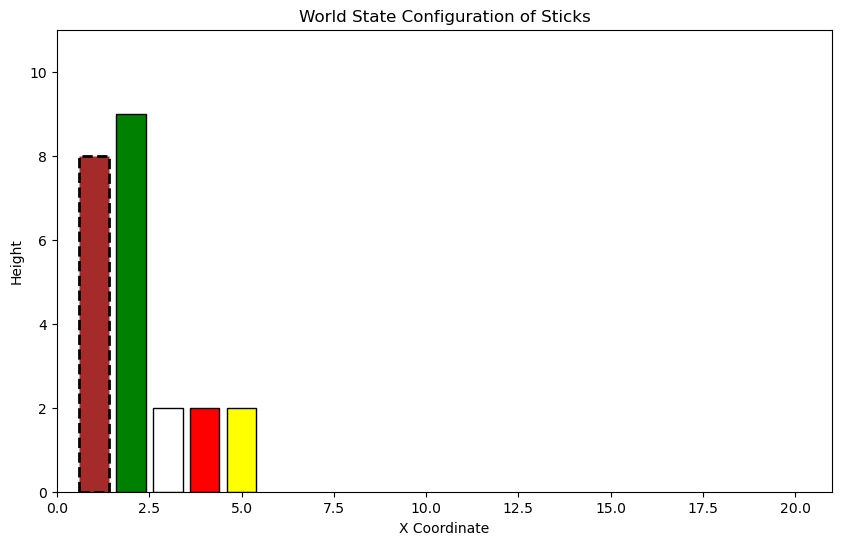

In [30]:
index = 569 
state = WorldState.from_dict(json_data[index]['sticks'])
print(rākau_data.loc[index, 'description'])
state.draw()

Based on this plot, it's probably enough to filter out samples with more than 10 sticks as being 'too complicated'. That'll help us keep the feature matrices compact, which hopefully will help with learning.

## Symmetries

There are multiple symmetries in this game. We could use these to augment the training data and hopefully teach the model some useful invariances relating to the target task. The goal will be to implement these in this notebook.

The symmetries are:
- Colour: For a given world state, if you permute the colours in the input and permute the colours in the output in the same way, then the resulting (world state, utterance) pair will still be valid.
- Size: The size is an ordinal variable, so as long as the sizes of the sticks are in the same relative order, the target utterance should not change.
- Position: Unless the words "Left" or "Right" are used, the order of the sticks does not matter (this could be false, strictly speaking since putting the sticks all on one side may change the most natural utterance)
- Reflection: If the words "Left" or "Right" are used, then if you reverse the order of the sticks, the target utterance will be valid after substituting "Right" for "Left" and vice-versa.

### Colour

We'll start by exploring colour, and we'll do this by calculating the set of all possible permutations of the available colours. Once we have that, we can choose all permutations that move at least one of the colours in the world state, and then we can apply all of those maps in the input and output to get every possible colour permutation of this world state.

In [37]:
from ataarangi.data import COLOURS
from itertools import permutations 

In [73]:
colour_to_id = dict(zip(COLOURS, range(len(COLOURS))))
id_to_colour = {v: k for k, v in colour_to_id.items()}
colour_to_id, id_to_colour

({'red': 0,
  'blue': 1,
  'green': 2,
  'yellow': 3,
  'black': 4,
  'white': 5,
  'brown': 6,
  'pink': 7},
 {0: 'red',
  1: 'blue',
  2: 'green',
  3: 'yellow',
  4: 'black',
  5: 'white',
  6: 'brown',
  7: 'pink'})

In [87]:
def create_permutatation_matrix(num_colors):
    # Generate all permutations of the array of colors
    color_indices = np.arange(num_colors)
    all_perms = list(permutations(color_indices))
    num_perms = len(all_perms)
    
    # Create a 3D array to hold the permutation transformation matrices
    transformation_tensor = np.zeros((num_perms, num_colors, num_colors), dtype=int)
    
    for i, perm in enumerate(all_perms):
        # Fill the appropriate places in the matrix to indicate the movement
        transformation_tensor[i, color_indices, perm] = 1

    return transformation_tensor

In [97]:
# Example usage
num_colors = len(COLOURS)  # Small example with 4 colors
permutation_matrix = create_permutatation_matrix(num_colors)

In [145]:
# Find all permutations where at least one colour in state.colors moves
colour_indices = sorted([colour_to_id[col] for col in state.colors.keys()])

permuatations = np.where(
    permutation_matrix[:, colour_indices, colour_indices] == 0
    )

permuatations

(array([    1,     2,     2, ..., 40319, 40319, 40319]),
 array([4, 3, 4, ..., 2, 3, 4]))

In [130]:
permutation_matrix[1,:,:]

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0]])

In [132]:
COLOURS

['red', 'blue', 'green', 'yellow', 'black', 'white', 'brown', 'pink']

In [135]:
state.colors.keys()

dict_keys(['brown', 'green', 'white', 'red', 'yellow'])